In [1]:
from Calibration import *

## Load forcing data 

#### Generated on Levante using ESMValTool

In [2]:
forcing = nc.Dataset('Data/ThunderCreek/HBVmountain_ERA5_ThunderCreek_1986_2005.nc')

## Calibration settings

In [3]:
ntimes = 1
MAXITER = 5
observation = 'Data/ThunderCreek/Discharge_ThunderCreek.csv' #GRDC observation data
path_to_shapefile = 'Data/ThunderCreek/Shapes/Thundercreek.shp' #Catchment shapefile from GRDC
path_to_dem = 'Data/ThunderCreek/dem_thundercreek_full.tif' #DEM tiles over the catchment area
path_to_nlcd = 'Data/NLCD_2001_Landuse.tif' 
start_year = 1986
years_warming_up = 2
end_year = 1995

## Run Calibration

In [4]:
paramsets = full_calibration(ntimes, observation, MAXITER, forcing, path_to_shapefile, path_to_dem, path_to_nlcd, start_year, years_warming_up, end_year)

Calibration results saved in cma_calibration_thundercreek.yml
Calibration is completed in 223.70938849449158 seconds


3.716666666666667

## Setting up the model

In [23]:
forcing = nc.Dataset('Data/ThunderCreek/HBVmountain_ERA5_ThunderCreek_1986_2005.nc')
model = BMI_HBVmountain(forcing_netcdf=forcing, path_to_shapefile='Data/Shapes/Thundercreek.shp', 
                        path_to_dem='Data/ThunderCreek/dem_thundercreek_full.tif', path_to_nlcd='Data/NLCD_2001_Landuse.tif')

In [24]:
config_file = model.setup()

RuntimeError: <PyCall.jlwrap (in a Julia function called from Python)
JULIA: MethodError: no method matching Vector{Float64}(::Matrix{Float64})

You might have used a 2d row vector where a 1d column vector was required.
Note the difference between 1d column vector [1,2,3] and 2d row vector [1 2 3].
You can convert to a column vector with the vec() function.
Closest candidates are:
  Array{T, N}(::AbstractArray{S, N}) where {T, N, S} at C:\Users\Vincent Hoogelander\AppData\Local\Programs\Julia-1.7.3\share\julia\base\array.jl:563
  Vector{T}() where T at C:\Users\Vincent Hoogelander\AppData\Local\Programs\Julia-1.7.3\share\julia\base\boot.jl:476
  Vector{T}(!Matched::Core.Compiler.AbstractRange{T}) where T at C:\Users\Vincent Hoogelander\AppData\Local\Programs\Julia-1.7.3\share\julia\base\range.jl:1286
  ...
Stacktrace:
 [1] convert(#unused#::Type{Vector{Float64}}, a::Matrix{Float64})
   @ Base .\array.jl:554
 [2] HRU_Input(Area_Elevations::Matrix{Float64}, Area_HRU::Float64, Area_Glacier::Vector{Float64}, Elevation_Count::Vector{Int64}, Nr_Elevationbands::Int64, Catchment_Elevation::Tuple{Int64}, Snow_Redistribution::Tuple{Int64}, Potential_Evaporation_Mean::Int64, Precipitation::Vector{Float64}, Riparian_Discharge::Float64, Temp_Elevation::Vector{Float64}, Total_Effective_Precipitation::Int64, Total_Interception_Evaporation::Float64)
   @ Main C:\Users\Vincent Hoogelander\Thesis\HBVmountain\General\Refactoring\structs.jl:5
 [3] invokelatest(::Any, ::Any, ::Vararg{Any}; kwargs::Base.Pairs{Symbol, Union{}, Tuple{}, NamedTuple{(), Tuple{}}})
   @ Base .\essentials.jl:716
 [4] invokelatest(::Any, ::Any, ::Vararg{Any})
   @ Base .\essentials.jl:714
 [5] _pyjlwrap_call(f::Type, args_::Ptr{PyCall.PyObject_struct}, kw_::Ptr{PyCall.PyObject_struct})
   @ PyCall C:\Users\Vincent Hoogelander\.julia\packages\PyCall\7a7w0\src\callback.jl:28
 [6] pyjlwrap_call(self_::Ptr{PyCall.PyObject_struct}, args_::Ptr{PyCall.PyObject_struct}, kw_::Ptr{PyCall.PyObject_struct})
   @ PyCall C:\Users\Vincent Hoogelander\.julia\packages\PyCall\7a7w0\src\callback.jl:44>

In [22]:
model.initialize(config_file)

NameError: name 'config_file' is not defined

In [10]:
model.get_value_ptr('Current_Date').year

1999

In [6]:
np.sum([0.077466593, 0.263523033, 0.545702942, 0.113307433])
np.sum([0.07746659266532895, 0.26352303291636425, 0.5457029415531742, 0.11330743286513256])

1.0

### Parameters

In [50]:
bare_parameters, forest_parameters, grass_parameters, rip_parameters,  slow_parameters, parameters_array =  Main.parameter_selection()
model.set_value('bare_parameters', bare_parameters)
model.set_value('forest_parameters', forest_parameters)
model.set_value('grass_parameters', grass_parameters)
model.set_value('rip_parameters', rip_parameters)
model.set_value('slow_parameters', slow_parameters)

In [11]:
# param_list = parameter_conversion('output_tc', nsmallest=10)

# model.set_value('bare_parameters', param_list[0][0])
# model.set_value('forest_parameters', param_list[0][1])
# model.set_value('grass_parameters', param_list[0][2])
# model.set_value('rip_parameters', param_list[0][3])
# model.set_value('slow_parameters', param_list[0][4])


### Forcings

In [12]:
model.set_value('Temperature', (forcing['temp_era5'].values).reshape(len(forcing),1))
model.set_value('Precipitation', (forcing['prec_era5'].values).reshape(len(forcing),1))

model.set_value('Date', list(forcing.index.values))
model.set_value('Current_Date', forcing.index.values[0])

### Initial settings

In [13]:
model.set_value('Elevation', Elevations(500, 500, 2500, 1500, 1500)) # 4 Elevation bands

model.set_value('Glacier', [0.0, 0.0, 0.0, 0.6]) # 60% of the area glacier at highest elevation band
model.set_value('Sunhours', [8.87, 10.30, 11.88, 13.65, 15.13, 15.97, 15.58, 14.25, 12.62, 11.87, 9.28, 8.45]) #Seattle
model.set_value('bare_input', HRU_Input([0.0,0.0,0.3,0.7], 0.32, [0.0, 0.0, 0.0, 0.6], [1,2,3,4], 4, (0,), (0,), 0, np.zeros(4), 0.01, np.zeros(4), 0, 0.0))
model.set_value('forest_input', HRU_Input([0.0,0.7,0.3,0.0], 0.45,np.zeros(4), [1,2,3,4], 4, (0,), (0,), 0, np.zeros(4), 0.01, np.zeros(4), 0, 0.0))
model.set_value('grass_input', HRU_Input([0.7,0.3,0.0,0.0], 0.21,np.zeros(4), [1,2,3,4], 4, (0,), (0,), 0, np.zeros(4), 0.01, np.zeros(4), 0, 0.0))
model.set_value('rip_input', HRU_Input([1.0,0.0,0.0,0.0], 0.02,np.zeros(4), [1,2,3,4], 4, (0,), (0,), 0, np.zeros(4), 0.01, np.zeros(4), 0, 0.0))
model.set_value('Total_Elevationbands', 4)
model.set_value('Elevation_Percentage', [0.15,0.26,0.36,0.23])
model.set_value('bare_storage', Storages(0,np.zeros(4),np.zeros(4),np.zeros(4),0))
model.set_value('forest_storage', Storages(0,np.zeros(4),np.zeros(4),np.zeros(4),0))
model.set_value('grass_storage', Storages(0,np.zeros(4),np.zeros(4),np.zeros(4),0))
model.set_value('rip_storage', Storages(0,np.zeros(4),np.zeros(4),np.zeros(4),0))

In [91]:
# model.set_value('Elevation', Main.Elevations(587.5, 396.0, 2746.0, 1572.36, 1572.36))
# model.set_value('Glacier', [0.0, 0.066, 0.7, 0.234])
# model.set_value('Sunhours', [8.87, 10.30, 11.88, 13.65, 15.13, 15.97, 15.58, 14.25, 12.62, 11.87, 9.28, 8.45]) #Seattle
# model.set_value('bare_input', Main.HRU_Input([0.001, 0.083, 0.636, 0.28], 0.32, [0.0, 0.021, 0.222, 0.074], [1,2,3,4], 4, (0,), (0,), 0, np.zeros(4), 0.01, np.zeros(4), 0, 0.0))
# model.set_value('forest_input', Main.HRU_Input([0.216, 0.396, 0.368, 0.02], 0.46,np.zeros(4), [1,2,3,4], 4, (0,), (0,), 0, np.zeros(4), 0.01, np.zeros(4), 0, 0.0))
model.set_value('grass_input', Main.HRU_Input([0.077466593, 0.263523033, 0.545702942, 0.113307432], 0.21,np.zeros(4), [1,2,3,4], 4, (0,), (0,), 0, np.zeros(4), 0.01, np.zeros(4), 0, 0.0))
# model.set_value('rip_input', Main.HRU_Input([0.65, 0.096, 0.232, 0.022], 0.01,np.zeros(4), [1,2,3,4], 4, (0,), (0,), 0, np.zeros(4), 0.01, np.zeros(4), 0, 0.0))
# model.set_value('Total_Elevationbands', 4)
# model.set_value('Elevation_Percentage', [0.15, 0.312, 0.416, 0.122])

## Running the model

In [7]:
Discharge = []
timestamp = []
while (model.get_value_ptr('Current_Date') < (datetime.date(1999, 1, 1))):  
    model.update()
    timestamp.append(model.get_value_ptr('Current_Date'))
    Discharge.append(model.get_value_ptr('Discharge'))

## Analysis

In [22]:
simulated_discharge_df = pd.DataFrame(
    {'simulation': Discharge},
    index=pd.to_datetime(timestamp)
)
combined_discharge = pd.merge(simulated_discharge_df, forcing['streamflow'], left_index=True, right_index=True)
combined_discharge

,simulation,streamflow
1986-01-02,0.000000,0.971722
1986-01-03,0.003807,0.953927
1986-01-04,0.006294,0.944712
1986-01-05,0.000164,0.944712
1986-01-06,0.015295,0.962825
...,...,...
1998-12-28,2.915435,3.302202
1998-12-29,3.730603,6.505580
1998-12-30,9.206945,8.332087
1998-12-31,4.039074,6.001606


## Clean up

In [17]:
model.finalize()

In [18]:
print(model)

In [4]:
generate_landuse_per_elevation('Data/dem_thundercreek.tif', 'Data/nlcd_thundercreek.tif')

[[[0.15, 0.312, 0.416, 0.122],
  [0.317, 0.456, 0.214, 0.013],
  587.5,
  396.0,
  2746.0,
  1572.355],
 [[0.001, 0.067, 0.706, 0.227], [0.0, 0.021, 0.224, 0.072]],
 [[0.001, 0.083, 0.636, 0.28]],
 [[0.217, 0.396, 0.368, 0.02]],
 [[0.077, 0.263, 0.546, 0.114]],
 [[0.65, 0.096, 0.232, 0.023]]]

In [7]:
bounds = gpd.read_file('Data/Shapes/Thundercreek.shp').bounds

In [9]:
west, south, east, north = bounds = bounds.loc[0]

In [10]:
west, south, east, north = bounds  = west - .05, south - .05, east + .05, north + .05

In [33]:
import elevation

In [34]:
dem_path = 'ThunderCreek_DEM.tif'
output = os.getcwd() + dem_path

In [42]:
# elevation.clip(bounds=bounds, output=dem_path, product='SRTM3')

In [114]:
# from elevation import cli
# cli.selfcheck()

In [83]:
soa_shape_map_path = "Data/Shapes/Thundercreek.shp"
soa_shape_map = gpd.read_file(soa_shape_map_path)

# soa_shape_map_geo = soa_shape_map.to_crs(epsg=4326)  # EPSG 4326 = WGS84 = https://epsg.io/4326
# print(soa_shape_map.iloc[0].geometry.centroid.x, soa_shape_map_geo.iloc[0].geometry.centroid.y)


ERROR:fiona._env:PROJ: proj_identify: C:\Users\Vincent Hoogelander\anaconda3\Library\share\proj\proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.


In [66]:
lon, lat = soa_shape_map_geo.iloc[0].geometry.centroid.x, soa_shape_map_geo.iloc[0].geometry.centroid.y

In [63]:
from suntime import Sun, SunTimeException

In [80]:
sun = Sun(lat, lon)

In [81]:
abd = datetime.date(2005, 12, 14)
abd_sr = sun.get_local_sunrise_time(abd)
abd_ss = sun.get_local_sunset_time(abd)

In [82]:
(abd_ss - abd_sr).seconds / 3600

8.316666666666666

In [111]:
def get_monthly_sunhours(lat, lon):
    sunhours = []
    sun = Sun(lat, lon)
    for i in range(1,13):
        timedelta = sun.get_local_sunset_time(datetime.date(2005, i, 14)) - sun.get_local_sunrise_time(datetime.date(2005, i, 14))
        sunhours.append(np.round(timedelta.seconds / 3600,2))
    return sunhours

In [112]:
get_monthly_sunhours(lat, lon)

[8.72, 10.17, 11.8, 13.63, 15.2, 16.08, 15.75, 14.42, 12.67, 10.9, 9.25, 8.32]

In [123]:
# from rasterio.warp import calculate_default_transform, reproject, Resampling

# dst_crs = 'EPSG:4326'

# with rasterio.open('Data/NLCD_2001_Landuse.tif') as src:
#     transform, width, height = calculate_default_transform(
#         src.crs, dst_crs, src.width, src.height, *src.bounds)
#     kwargs = src.meta.copy()
#     kwargs.update({
#         'crs': dst_crs,
#         'transform': transform,
#         'width': width,
#         'height': height
#     })

# with rasterio.open('/tmp/Data/NLCD_2001_Landuse.tif', 'w', **kwargs) as dst:
#     for i in range(1, src.count + 1):
#         reproject(
#             source=rasterio.band(src, i),
#             destination=rasterio.band(dst, i),
#             src_transform=src.transform,
#             src_crs=src.crs,
#             dst_transform=transform,
#             dst_crs=dst_crs,
#             resampling=Resampling.nearest)

In [17]:
import fiona
import rasterio
import rasterio.mask



ERROR:fiona._env:PROJ: proj_identify: C:\Users\Vincent Hoogelander\anaconda3\Library\share\proj\proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.


In [3]:
full_calibration(1, 20)

TypeError: wrapped_objective_function() missing 1 required positional argument: 'iterations'

In [8]:
import fiona
with fiona.open("Data/Shapes/Thundercreek.shp", "r") as shapefile:
    shapes = [feature["geometry"] for feature in shapefile]

with rasterio.open("Data/NLCD_2001_Landuse.tif") as src:
    out_image, out_transform = rasterio.mask.mask(src, shapes, crop=True, nodata=-9999)
    out_image = out_image[out_image != -9999]
    out_meta = src.meta
    arr = np.expand_dims(out_image.flatten(), 0).T

    
    
get_landuse_from_raster(arr)
# arr = out_image.read(masked=True)
data = rasterio.open('Data/dem_thundercreek.tif', shapefile=shapes, masked=True)
data

<open DatasetReader name='Data/dem_thundercreek.tif' mode='r'>

In [14]:

def generate_array_from_raster(str_path_to_rasterfile, str_path_to_shapefile=None):
    if str_path_to_shapefile != None:
        with fiona.open(str_path_to_shapefile, "r") as shapefile:
            shapefile = [feature["geometry"] for feature in shapefile]

        with rasterio.open(str_path_to_rasterfile) as src:
            out_image, out_transform = rasterio.mask.mask(src, shapefile, crop=True)
#             out_image = out_image[out_image <97]
            out_image = ma.masked_values(out_image, 0)
            arr = np.expand_dims(out_image.flatten(), 0).T    
    else:
        raster = rasterio.open(str_path_to_rasterfile)
        arr = raster.read(masked=True)
        arr = np.expand_dims(arr.flatten(), 0).T    
    return arr

def get_elevations_from_raster(raster_array_flattened, nbands):
   
    n, bins, patches = plt.hist(raster_array_flattened, bins=nbands)
    plt.close()
    tot_pixels = n.sum()
#     print(raster_array_flattened.max())
#     raster_array_flattened = raster_array_flattened.filled(np.nan)
    av_elevation = round(raster_array_flattened.mean(),3)
#     av_elevation = raster_array_flattened.mean()
    elevation_list = []
    for i in range(nbands):
        elevation_percentage = n[i] / tot_pixels
        elevation_list.append(round(elevation_percentage, 3))
    min_elevation = np.min(bins)
    max_elevation = np.max(bins)
    return elevation_list, bins, min_elevation, max_elevation, av_elevation

def get_landuse_from_raster(raster_array_flattened):
    n, bins, patches = plt.hist(raster_array_flattened, bins=np.arange(96))
    plt.close()
    
    tot_pixels = n.sum()
    
    bare = np.sum(n[[12, 22, 22, 24, 31]]) / tot_pixels 
    forest = np.sum(n[40:46]) / tot_pixels 
    grass = (np.sum(n[50:83])+ n[21]) /tot_pixels 
    rip = np.sum(n[[11, 90, 94]]) /tot_pixels  
    
    

    landuse_list = [round(bare,3), round(forest,3), round(grass,3), round(rip,3)] 
    return landuse_list

def generate_shapefiles_per_landuse(landuse, str_path_to_rasterfile, str_path_to_shapefile=None):  
        
    with rasterio.Env():
        if str_path_to_shapefile != None:
            with fiona.open(str_path_to_shapefile, crs='epsg:4326') as shapefile:
                shapefile = [feature["geometry"] for feature in shapefile]
            with rasterio.open(str_path_to_rasterfile) as src:
                image, out_transform = rasterio.mask.mask(src, shapefile, crop=True)
                image = ma.masked_values(image, 0)
                image = image.astype(np.float32)
                image = image.filled(np.nan)

        else:
            with rasterio.open(str_path_to_rasterfile) as src:
                image = src.read() # first band
        if landuse == 'glacier':
            image[(image == 12)] = -9999
        if landuse == 'bare':
            image[(image == 12) | (image == 22) | (image == 23)  | (image == 24) | (image == 31)] = -9999
        if landuse == 'forest':
            image[(image == 41) | (image == 42) | (image == 43)] = -9999
        if landuse == 'grass':
            image[(image == 21) | (image == 51) | (image == 52) | (image == 71) | (image == 72) | (image == 73) | (image == 74) | (image == 81) | (image == 82)] = -9999
        if landuse == 'rip':
            image[(image == 11) | (image == 90) | (image == 95)] = -9999


        if str_path_to_shapefile != None:
            results = (
            {'properties': {'raster_val': v}, 'geometry': s}
            for i, (s, v) 
            in enumerate(
                shapes(image, mask=(image ==-9999), transform= out_transform)))
        else:
            results = (
            {'properties': {'raster_val': v}, 'geometry': s}
            for i, (s, v) 
            in enumerate(
                shapes(image, mask=(image ==-9999), transform= src.transform)))            
    geoms = list(results)
    gpd_polygonized_raster  = gp.GeoDataFrame.from_features(geoms, crs='epsg:4326')
    return gpd_polygonized_raster

def clip_elevation_per_landuse(gpd_polygonized_raster, str_path_to_elevation, str_path_to_shapefile=None, export_tif=False):
    gdf = gpd_polygonized_raster.dissolve()
    coords = [json.loads(gdf.to_json())['features'][0]['geometry']] 
    if str_path_to_shapefile != None:

        with fiona.open(str_path_to_shapefile) as shapefile:
            shapefile = [feature["geometry"] for feature in shapefile]
        with rasterio.open(str_path_to_elevation) as src:
#             out_img, out_transform = rasterio.mask.mask(src, shapefile, crop=True)
            out_img, out_transform = rasterio.mask.mask(src, coords, crop=True)
            out_img = ma.masked_values(out_img, 0)
            out_img = out_img.astype(np.float32)
            out_img = out_img.filled(np.nan) 
    
    else:
        data = rasterio.open(str_path_to_elevation, shapefile=None)
        out_img, out_transform = mask(data, shapes=coords)
        out_img = np.expand_dims(out_img.flatten(), 0).T
        out_img = ma.masked_values(out_img, data.nodata)
    
    if export_tif == True:
        out_meta = data.meta.copy()
        with rasterio.open('elevationlanduse.tif', "w", **out_meta) as dest:
            dest.write(out_img)
    
    return out_img 

def generate_landuse_per_elevation(str_path_to_elevation, str_path_to_landuse, str_path_to_shapefile=None, nbands=4):
    elevation_array = generate_array_from_raster(str_path_to_elevation, str_path_to_shapefile)
    landuse_array = generate_array_from_raster(str_path_to_landuse, str_path_to_shapefile)
    
    elevation_list, bins, min_elevation, max_elevation, av_elevation = get_elevations_from_raster(elevation_array, nbands=nbands)
    landuse_catchment = get_landuse_from_raster(landuse_array)
    
    tot_elevations = [[elevation_list, landuse_catchment, (max_elevation-min_elevation)/nbands, min_elevation, max_elevation, av_elevation]]
    landuse = ['glacier', 'bare', 'forest', 'grass', 'rip']
    for x in landuse:
        gpd_polygonized_raster = generate_shapefiles_per_landuse(x, str_path_to_landuse, str_path_to_shapefile)
        if not gpd_polygonized_raster.empty:
            arr = clip_elevation_per_landuse(gpd_polygonized_raster, str_path_to_elevation, str_path_to_shapefile)
            raster_array_flattened = np.expand_dims(arr.flatten(), 0).T
            elevation_list, bins, min_elevation, max_elevation, av_elevation = get_elevations_from_raster(raster_array_flattened, nbands=nbands)

            if x == 'glacier':
                tot_elevations.append([elevation_list, list(np.around(np.array(elevation_list)*landuse_catchment[0], 3))]) 
            else:
                tot_elevations.append([elevation_list])

#         tot_elevations.append([elevation_list])
    return tot_elevations

In [25]:
el = generate_landuse_per_elevation(path_to_dem, 'Data/NLCD_2001_Landuse.tif', 'Data/Shapes/Thundercreek.shp')

In [145]:
el

[[[0.15, 0.312, 0.416, 0.122],
  [0.145, 0.209, 0.098, 0.006],
  587.5,
  396.0,
  2746.0,
  1572.369],
 [[0.001, 0.067, 0.705, 0.227], [0.0, 0.01, 0.102, 0.033]],
 [[0.001, 0.083, 0.634, 0.281]],
 [[0.216, 0.395, 0.37, 0.019]],
 [[0.077, 0.264, 0.546, 0.113]],
 [[0.645, 0.101, 0.232, 0.023]]]

In [6]:
generate_landuse_per_elevation("Data/dem_thundercreek.tif", "Data/nlcd_thundercreek.tif", nbands=4)

[[[0.15, 0.312, 0.416, 0.122],
  [0.317, 0.456, 0.214, 0.013],
  587.5,
  396.0,
  2746.0,
  1572.355],
 [[0.001, 0.067, 0.706, 0.227], [0.0, 0.021, 0.224, 0.072]],
 [[0.001, 0.083, 0.636, 0.28]],
 [[0.217, 0.396, 0.368, 0.02]],
 [[0.077, 0.263, 0.546, 0.114]],
 [[0.65, 0.096, 0.232, 0.023]]]

In [82]:
clip_elevation_per_landuse

NameError: name 'generate_shapefiles_per_elevation' is not defined

In [83]:
# generate_landuse_per_elevation("Data/dem_thundercreek.tif", "Data/nlcd_thundercreek.tif", nbands=4)

In [140]:
# x, = generate_shapefiles_per_landuse('bare', "Data/NLCD_2001_Landuse.tif", "Data/Shapes/Thundercreek.shp")
# s.to_file('MyGeometries.shp', driver='ESRI Shapefile')


In [87]:
y = generate_shapefiles_per_landuse('bare', "Data/nlcd_thundercreek.tif")
y.to_file('MyGeometries2.shp', driver='ESRI Shapefile')

In [40]:
len(generate_array_from_raster("Data/nlcd_thundercreek.tif")), len(generate_array_from_raster("Data/NLCD_2001_Landuse.tif", "Data/Shapes/Thundercreek.shp"))


(755465, 695520)

In [199]:
with fiona.open("Data/Shapes/Thundercreek.shp", crs='epsg:4326') as shapefile:
    shapefile = [feature["geometry"] for feature in shapefile]
y = gpd.read_file("Data/Shapes/Thundercreek.shp")
# y = y.to_crs(crs='epsg:4326')
# f = [json.loads(y.to_json())['features'][0]['geometry']]
# f
def getFeatures(gdf):
    """Function to parse features from GeoDataFrame in such a manner that rasterio wants them"""
    import json
    return [json.loads(gdf.to_json())['features'][0]['geometry']]
getFeatures(y)

[{'type': 'Polygon',
  'coordinates': [[[-121.0375, 48.4958],
    [-121.056, 48.5106],
    [-121.0994, 48.5161],
    [-121.1258, 48.5316],
    [-121.131, 48.544],
    [-121.1368, 48.5537],
    [-121.1731, 48.5685],
    [-121.1875, 48.575],
    [-121.1856, 48.594],
    [-121.1727, 48.5977],
    [-121.1653, 48.6069],
    [-121.156, 48.6144],
    [-121.1429, 48.636],
    [-121.15, 48.6417],
    [-121.1386, 48.6549],
    [-121.1231, 48.6606],
    [-121.08, 48.6671],
    [-121.0641, 48.6808],
    [-121.0495, 48.6978],
    [-121.035, 48.6883],
    [-121.0366, 48.6691],
    [-121.0304, 48.6486],
    [-121.015, 48.6308],
    [-121.0061, 48.6231],
    [-120.9815, 48.5945],
    [-120.9391, 48.5888],
    [-120.9252, 48.5899],
    [-120.9061, 48.5856],
    [-120.8944, 48.579],
    [-120.8583, 48.5819],
    [-120.8324, 48.5704],
    [-120.8232, 48.5539],
    [-120.8227, 48.5478],
    [-120.825, 48.5458],
    [-120.8526, 48.5515],
    [-120.8622, 48.5317],
    [-120.8886, 48.5407],
    [-120.9005, 4

In [99]:
with rasterio.Env():

    with fiona.open("Data/Shapes/Thundercreek.shp", "r") as shapefile:
        shapefile = [feature["geometry"] for feature in shapefile]
    with rasterio.open("Data/NLCD_2001_Landuse.tif") as src:
        image, out_transform = rasterio.mask.mask(src, shapefile, crop=True, nodata=-111)
        out_meta = src.meta
#         image = image[image != -99999]  
    out_meta.update({"driver": "GTiff",
                     "height": image.shape[1],
                     "width": image.shape[2],
                     "transform": out_transform})

#     with rasterio.open("masked_image.tif", "w", **out_meta, crs='epsg:4326') as dest:
#         dest.write(image)

    with rasterio.open("Data/nlcd_thundercreek.tif") as src:
        image2 = src.read() # first band

In [132]:
out_meta

{'driver': 'GTiff',
 'dtype': 'uint8',
 'nodata': None,
 'width': 1120,
 'height': 621,
 'count': 1,
 'crs': CRS.from_wkt('GEOGCS["WGS 84",DATUM["World Geodetic System 1984",SPHEROID["WGS 84",6378137,298.257223563]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AXIS["Latitude",NORTH],AXIS["Longitude",EAST]]'),
 'transform': Affine(0.0003258720163717725, 0.0, -121.18759845756873,
        0.0, -0.0003258720163695927, 48.69795605607634)}

In [125]:
image.shape, image2.shape, image3.shape

((1, 621, 1120), (1, 695, 1087), (1, 621, 1120))

In [101]:
image3 = image.astype(np.float32)

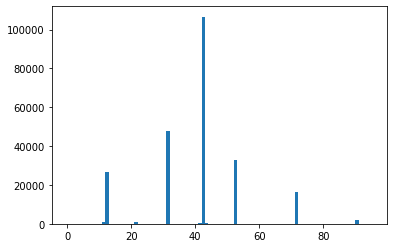

In [90]:
n, bins, patches = plt.hist(image2[image2>0], bins=np.arange(96))

In [102]:
image3

array([[[145., 145., 145., ..., 145., 145., 145.],
        [145., 145., 145., ..., 145., 145., 145.],
        [145., 145., 145., ..., 145., 145., 145.],
        ...,
        [145., 145., 145., ..., 145., 145., 145.],
        [145., 145., 145., ..., 145., 145., 145.],
        [145., 145., 145., ..., 145., 145., 145.]]], dtype=float32)